<a href="https://colab.research.google.com/github/Sanjidh090/llama-ocr/blob/main/titanic-tutorial01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction

In this notebook, I will go through my solution and analysis of the [Kaggle Titanic survival prediction competition](https://www.kaggle.com/c/titanic/overview). The aim of this competition is simple, given what we know about a passenger aboard the Titanic, can we predict whether or not this passenger has survived? In other words, we want to train a machine learning model to learn the relationship between passenger features and their survival outcome and subsequently make survival predictions on passenger data that our model has not seen before.

This is a classic beginner's project suited for anyone who is looking to gain some hands-on experience with data science and machine learning. I hope you will find some value out of this notebook.

I drew inspirations from the following notebooks in the making of this notebook:
- [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions) by [Manav Sehgal](https://www.kaggle.com/startupsci)
- [Titanic Top 4% With Emsemble Modelling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) by [Yassin Ghouzam](https://www.kaggle.com/yassineghouzam)
    
Kaggle competitions comprise of a minimum of 3 datasets that you can find and download from the competition webpage. The three datasets are:

1. Training set
2. Test set
3. Sample submission

## Training set
This is the dataset that you will be working on predominantly. You will perform manipulation and analysis on this dataset to extract insights as well as build a predictive model. The goal here is to determine and create features that will help us predict the outcome of our data. There are two types of problems in machine learning and they are classfication and regression problems. Titanic is an example of a classification problem where the outcome is categorical. In other words, our model needs to be able to predict and classify outcomes as either one of two categories, survived or did not survive the titanic.

## Test set
Once our model has been built, we need to make sure that it does not merely fit our training set well but also able to make predictions on out-of-samples data, that is data our model has not been trained on. We will use the testing set as inputs to the model that we have built and make predictions based on those inputs. This is where you will be assessed in the competition i.e. how accurate is your model at predicting new observations. It is also important to note that every competition has different metrics in which they assess model accuracy and you can find this information under the evaluation tab in the overview section of the competition page. For this competition, the evaluation metric is simply the percentage of passengers that are correctly predicted by our model.

## Sample submission
This is the format in which you want to submit your final solution. Pay attention to the column headings and shape of the sample submission to get a better understanding on how you should structure your final dataframe for submission.

# 1. Import libraries

Here I will import the libraries that I will be using in my notebook. Libraries are essentially extensions to Python that consist of functions that are handy to have when we are performing our analysis.

In [5]:
# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
pip install catboost

# 2. Import and read data

Now import and read the 3 datasets as outlined in the introduction.

In [7]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
ss = pd.read_csv("/content/gender_submission.csv")

Let's have a look at the datasets.

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)

Training set shape:  (891, 12)
Test set shape:  (418, 11)


Note that the test set has one column less than training set, the Survived column. This is because Survived is our response variable, or sometimes called a target variable. Our job is to analyse the data in the training set and predict the survival of the passengers in the test set.

What about sample submission?

In [11]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [12]:
ss.shape

(418, 2)

So, our final dataframe that is to be submitted should look something like this, 418 rows and 2 columns, one for PassengerId and one for Survived.

# 3. Data description

Here I will outline the definitions of the columns in the titanic dataset. You can find this information under the [data](https://www.kaggle.com/c/titanic/data) tab of the competition page.

- Survived: 0 = Did not survive, 1 = Survived

- Pclass: Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.

- Sex: Male or female

- Age: Age in years, fractional if less than 1

- SibSp: Number of siblings or spouses aboard the titanic

- Parch: Number of parents or children aboard the titanic

- Ticket: Passenger ticket number

- Fare: Passenger fare

- Cabin: Cabin number

- Embarked: Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

# 4. Exploratory Data Analysis (EDA)

Exploratory data analysis is the process of visualising and analysing data to extract insights. In other words, we want to summarise important characteristics and trends in our data in order to gain a better understanding of our dataset.

## 4.1 Data types, missing data and summary statistics

In [13]:
# Non-null count and data types of the training and test set

train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [14]:
# Missing data in training set by columns

train.isnull().sum().sort_values(ascending = False)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0


In [15]:
# Missing data in test set by columns

test.isnull().sum().sort_values(ascending = False)

,0
Cabin,327
Age,86
Fare,1
PassengerId,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0
Ticket,0


Seems like Age, Cabin and Embarked colummns in the training set have missing data  while Age, Fare and Cabin in the test set have missing data. Another way to to diagnose this is via the missingno library.

<Axes: >

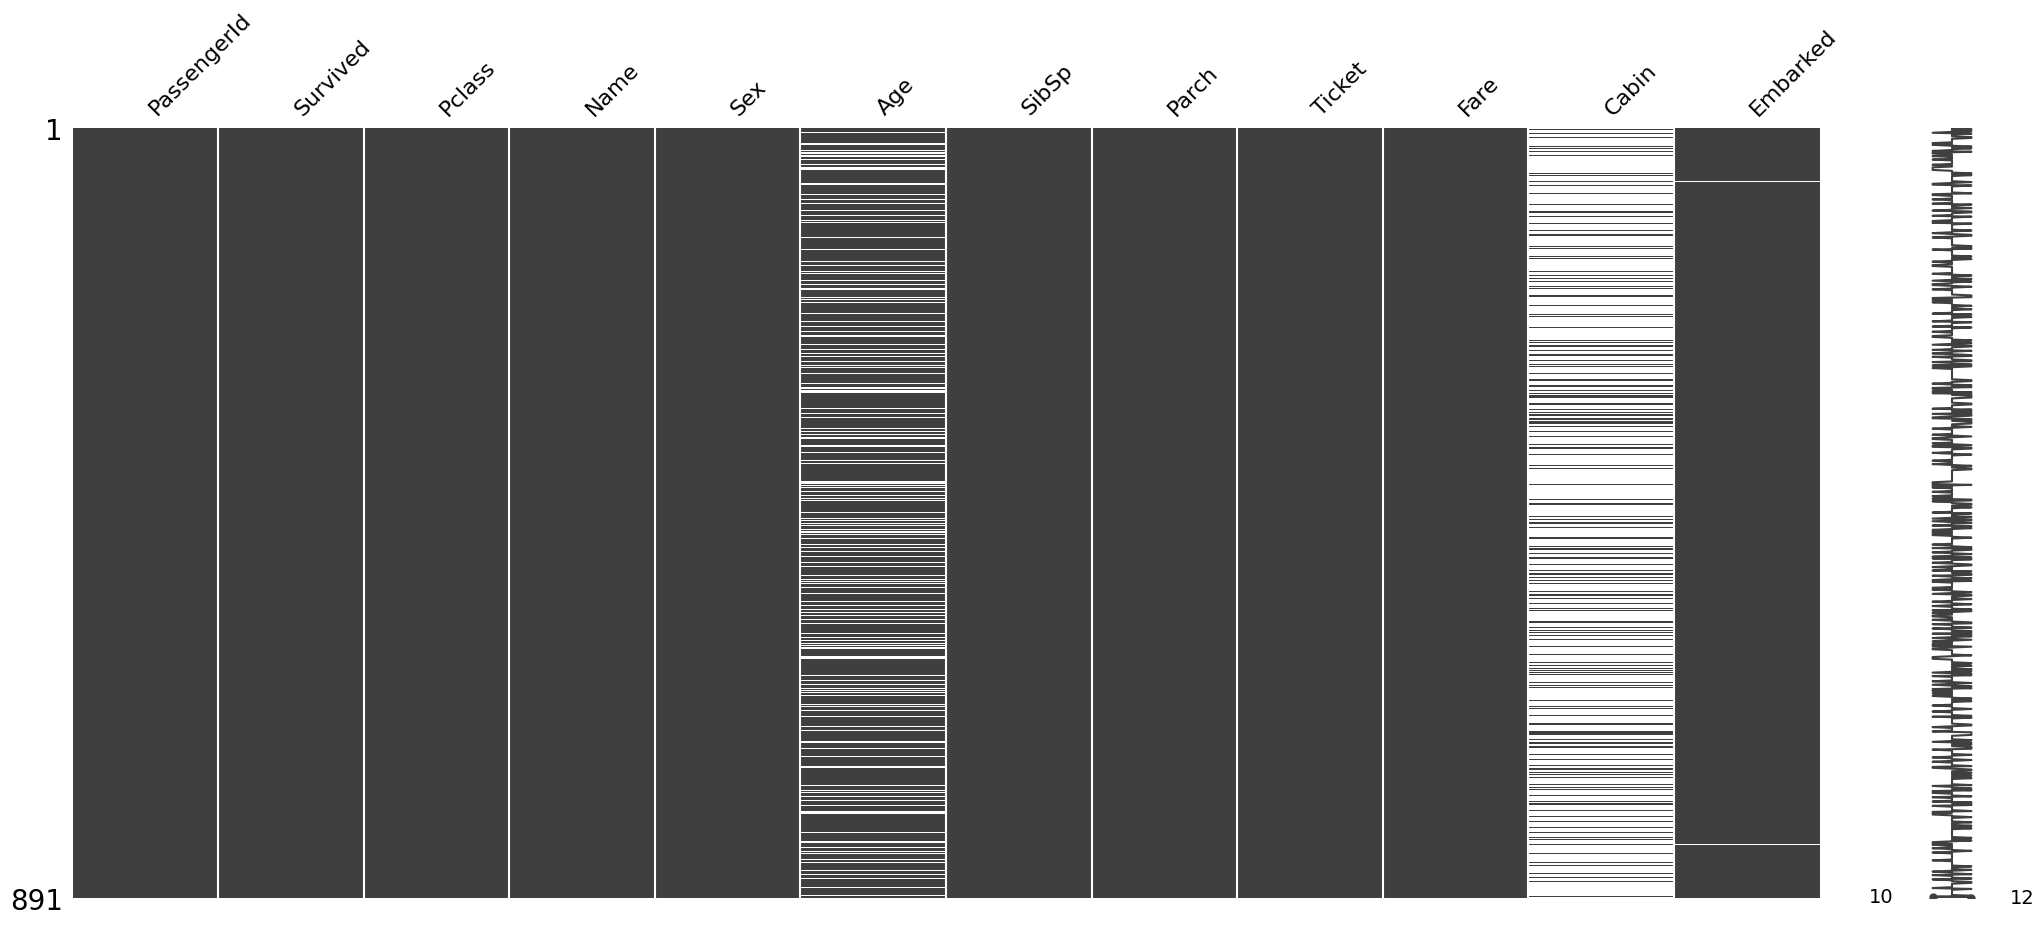

In [16]:
# Missing data in training set

missingno.matrix(train)

<Axes: >

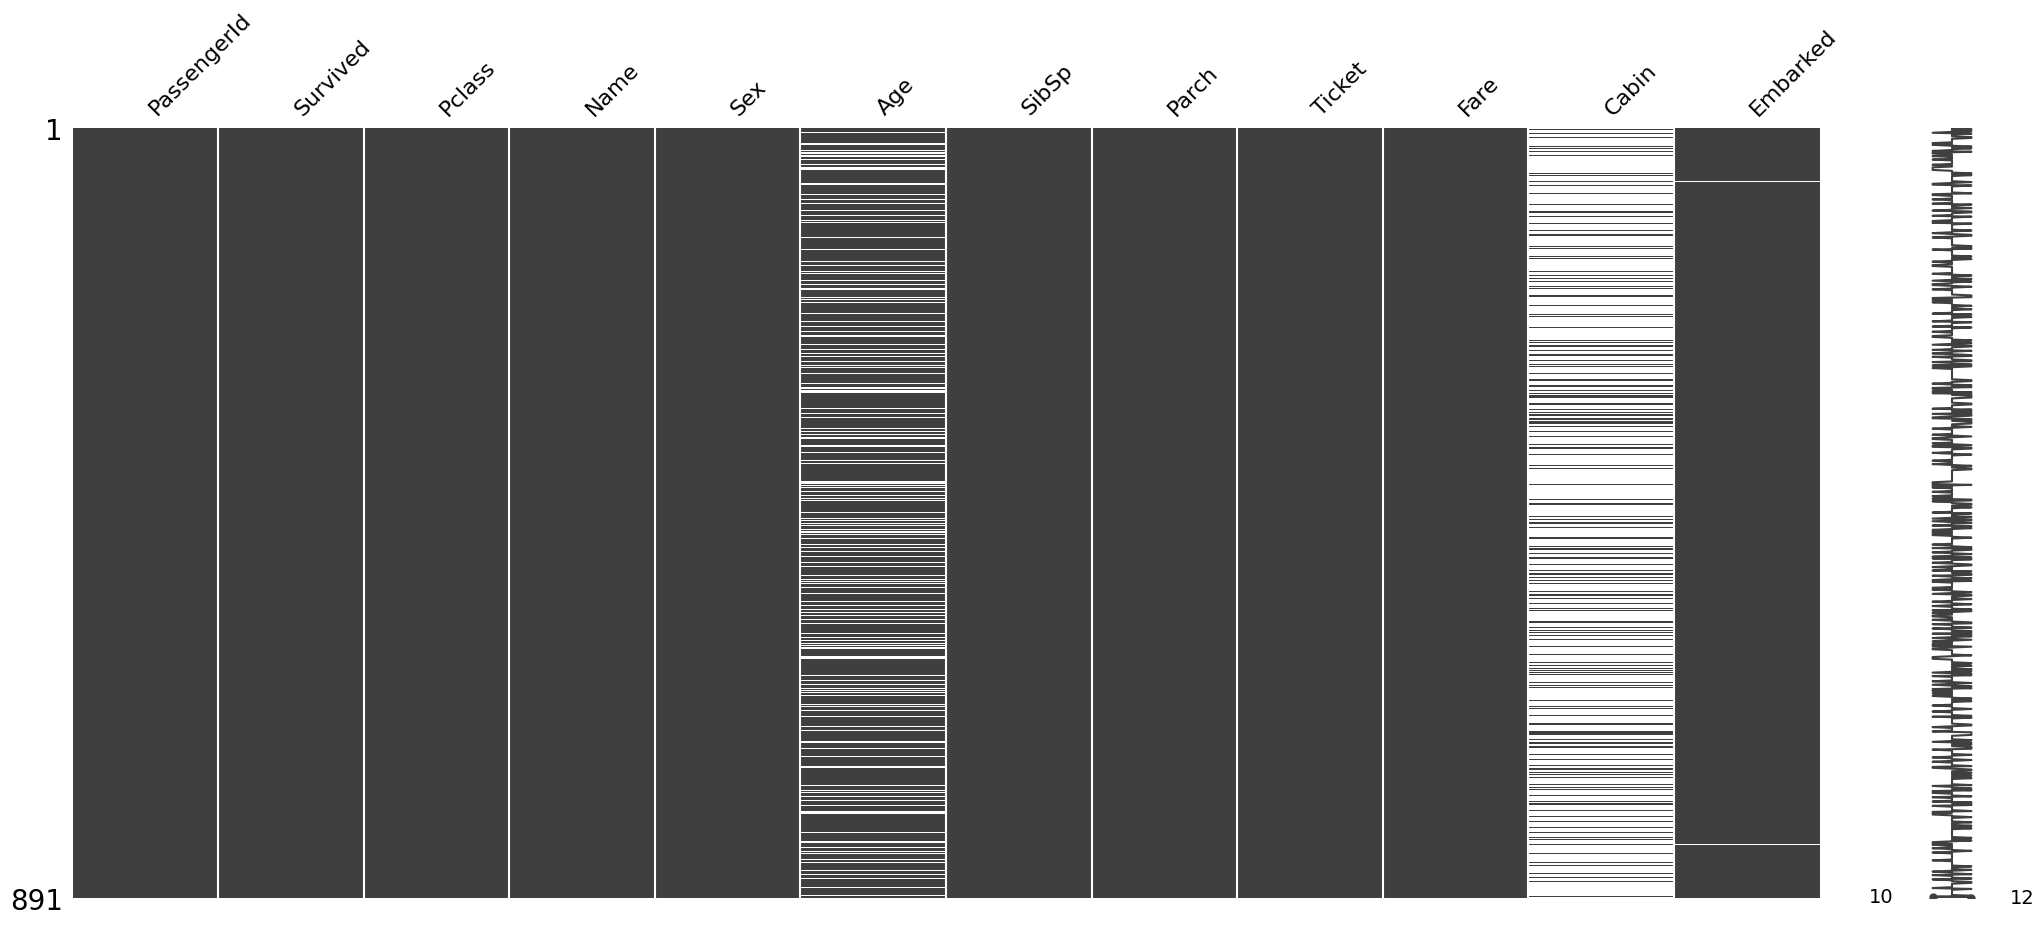

In [17]:
# Missing data in test set

missingno.matrix(train)

In [18]:
# Summary statistics for training set

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
# Summary statistics for test set

test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 4.2 Feature analysis

A dataframe is made up of rows and columns. Number of rows correspond to the number of observations in our dataset whereas columns, sometimes called features, represent characteristics that help describe these observations. In our dataset, rows are the passengers on the titanic whereas columns are the features that describe the passengers like their age, gender etc.

Before we move on, it is also important to note the difference between a categorical variable and a numerical variable. Categorical variables, as the name suggests, have values belonging to one of two or more categories and there is usually no intrinsic ordering to these categories. An example of this in our data is the Sex feature. Every passenger is distinctly classified as either male or female. Numerical variables, on the other hand, have a continuous distribution. Some examples of numerical variables are the Age and Fare features.

Knowing if a feature is a numerical variable or categorical variable helps us structure our analysis more properly. For instance, it doesn't make sense to calculate the average of a categorical variable such as gender simply because gender is a binary classification and therefore has no intrinsic ordering to its values.

In this next section of the notebook, we will analyse the features in our dataset individually and see how they correlate with survival probability.

## 4.2.1 Categorical variables

Categorical variables in our dataset are Sex, Pclass and Embarked.

## Categorical variable: Sex

In [20]:
# Value counts of the sex column

train['Sex'].value_counts(dropna = False)

# Comment: There are more male passengers than female passengers on titanic

,count
Sex,
male,577
female,314


In [21]:
# Mean of survival by sex

train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

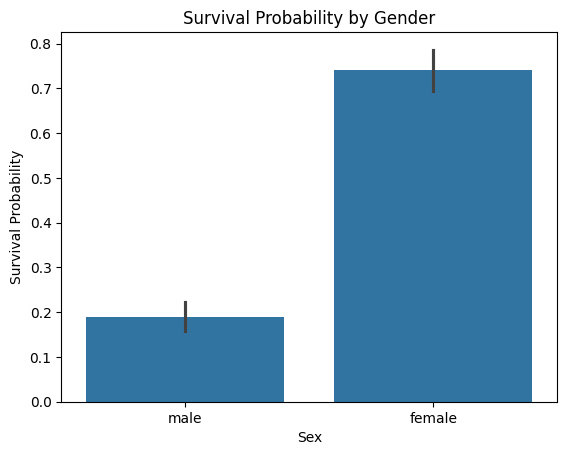

In [22]:
sns.barplot(x = 'Sex', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

# Comment: Female passengers are more likely to survive

## Categorical variable: Pclass

In [23]:
# Value counts of the Pclass column

train['Pclass'].value_counts(dropna = False)

,count
Pclass,
3,491
1,216
2,184


In [24]:
# Mean of survival by passenger class

train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival Probability by Passenger Class')

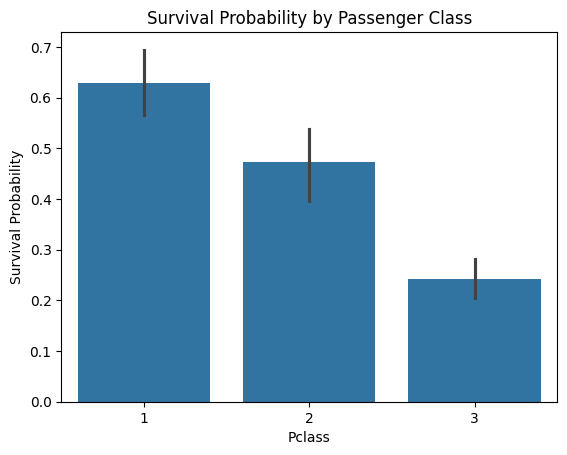

In [25]:
sns.barplot(x = 'Pclass', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

# Comment: Survival probability decrease with passenger class, first class passengers are prioritised during evacuation

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

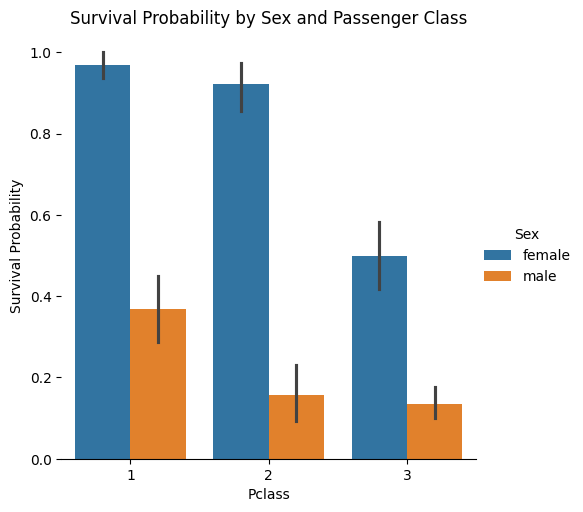

In [27]:
# Survival by gender and passenger class

g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

## Categorical variable: Embarked

In [28]:
# Value counts of the Embarked column

train['Embarked'].value_counts(dropna = False)

# Comment: Two missing values in the Embarked column

,count
Embarked,
S,644
C,168
Q,77
NaN,2


In [29]:
# Mean of survival by point of embarkation

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

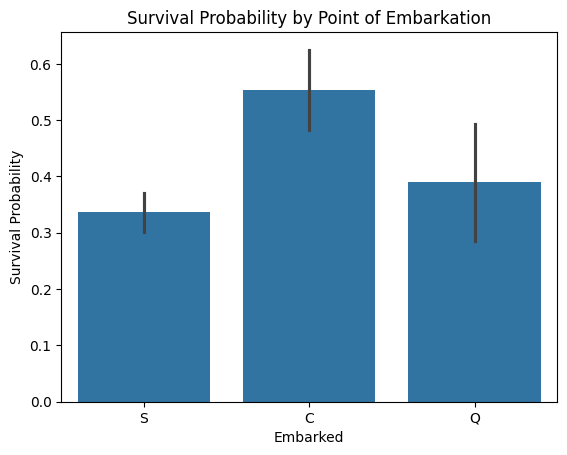

In [30]:
sns.barplot(x = 'Embarked', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

Survival probability is highest for location C and lowest for location S.

Is there a reason for this occurence? We can formulate a hypothesis whereby the majority of the first class passengers have embarked from location C and because they have a highest survival probability, this has resulted in location C having a highest survival probability. Alternatively, there could have been more third class passengers that embarked from location S and because they have the lowest survival probability, this has caused location S to have the lowest survival probability.

Let us now test this hypothesis.

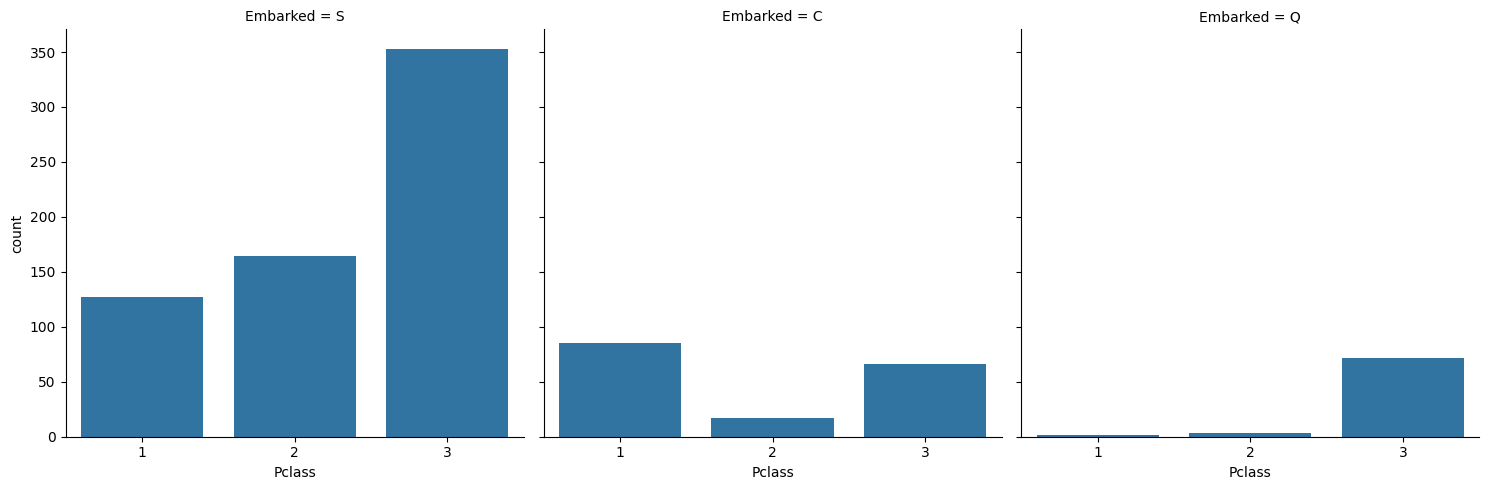

In [33]:
sns.catplot(x='Pclass', col='Embarked', data=train, kind='count')

Our hypothesis appears to be true. Location S has the most third class passengers whereas location C has the most first class passengers.

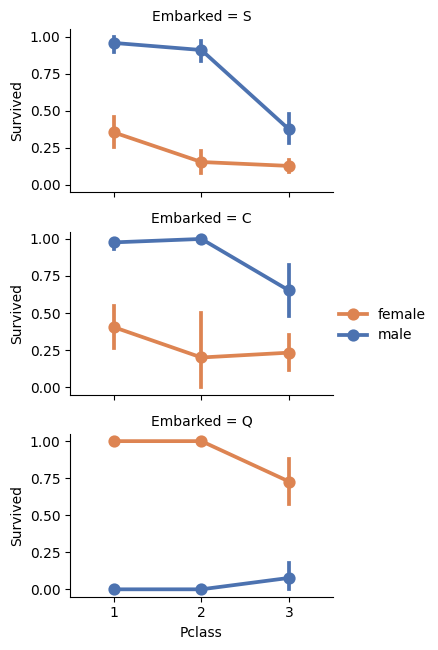

In [35]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train, row = 'Embarked', height = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

## 4.2.2 Numerical variables

Numerical variables in our dataset are SibSp, Parch, Age and Fare.

## Detect and remove outliers in numerical variables

Outliers are data points that have extreme values and they do not conform with the majority of the data. It is important to address this because outliers tend to skew our data towards extremes and can cause inaccurate model predictions. I will use the Tukey method to remove these outliers.

In [36]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.
    """
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [37]:
# Outliers in numerical variables

train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [38]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


## Numerical variables correlation with survival

<Axes: >

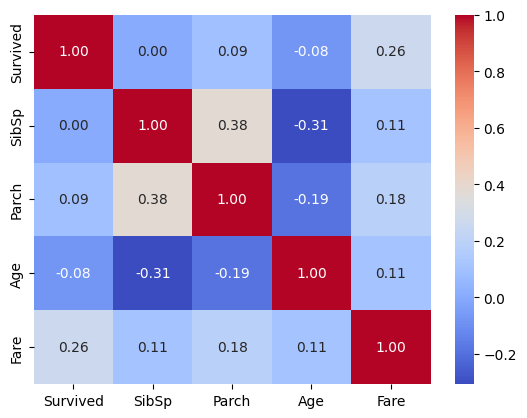

In [39]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# Comment: Fare seems to be the only feature that has a substantial correlation with survival

## Numerical variable: SibSp

In [40]:
# Value counts of the SibSp column

train['SibSp'].value_counts(dropna = False)

,count
SibSp,
0,608
1,209
2,28
4,18
3,13
5,5


In [41]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

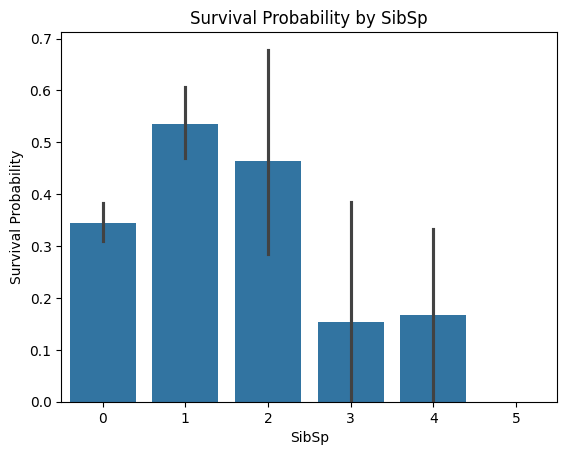

In [42]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

## Numerical variable: Parch

In [43]:
# Value counts of the Parch column

train['Parch'].value_counts(dropna = False)

,count
Parch,
0,678
1,118
2,70
5,5
3,5
4,4
6,1


In [44]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

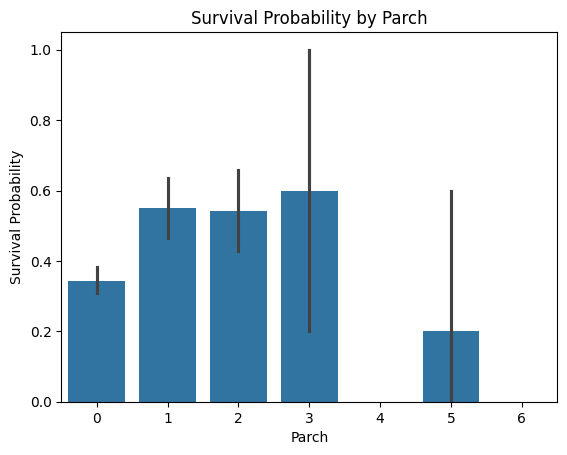

In [45]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

## Numerical variable: Age

In [46]:
# Null values in Age column

train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

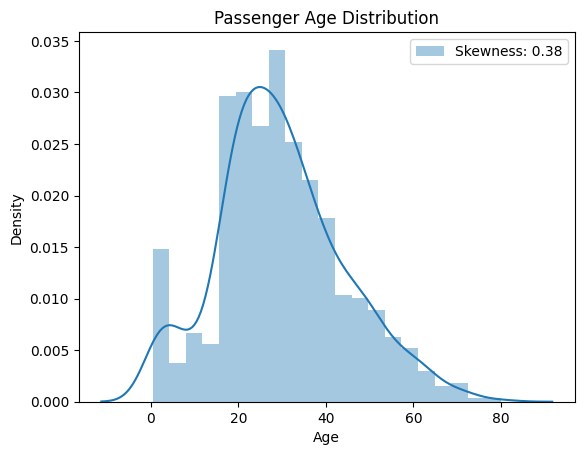

In [47]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

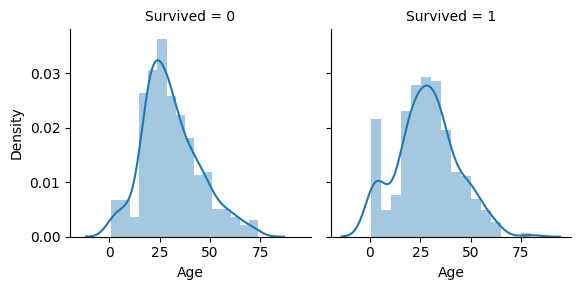

In [48]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

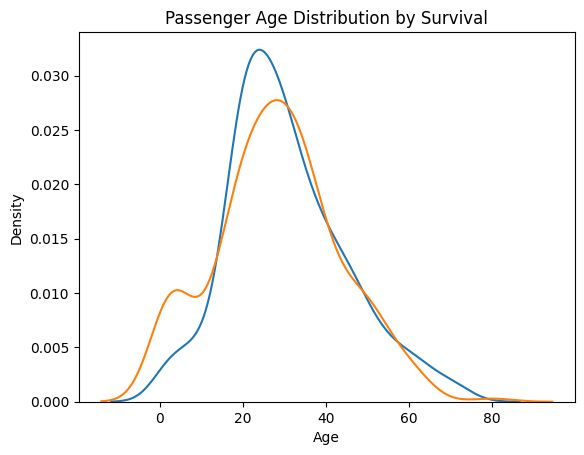

In [49]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

## Numerical variable: Fare

In [50]:
# Null values of Fare column

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

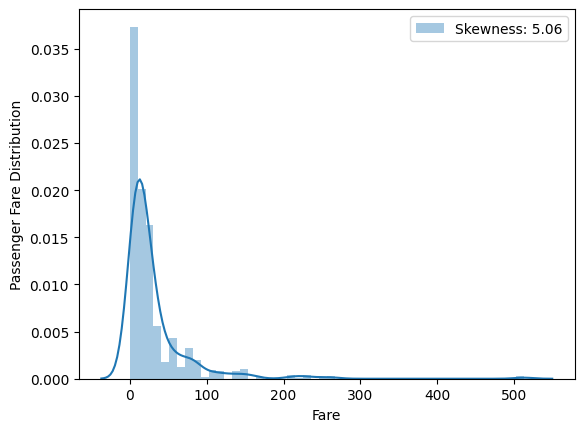

In [51]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

Fare seems to have a high skewness. We will address this issue later on in the notebook via log transformation.

# 5. Data preprocessing

Data preprocessing is the process of getting our dataset ready for model training. In this section, we will perform the following preprocessing steps:

- Drop and fill missing values
- Data trasformation (log transformation)
- Feature engineering
- Feature encoding

## 5.1 Drop and fill missing values

In [52]:
# Drop ticket and cabin features from training and test set

train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)

I have decided to drop both ticket and cabin for simplicity of this tutorial but if you have the time, I would recommend going through them and see if they can help improve your model.

In [53]:
# Missing values in training set

train.isnull().sum().sort_values(ascending = False)

,0
Age,170
Embarked,2
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0
Fare,0


In [54]:
# Compute the most frequent value of Embarked in training set

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [55]:
# Fill missing value in Embarked with mode

train['Embarked'].fillna(mode, inplace = True)

In [56]:
# Missing values in test set

test.isnull().sum().sort_values(ascending = False)

,0
Age,86
Fare,1
PassengerId,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0
Embarked,0


In [57]:
# Compute median of Fare in test set

median = test['Fare'].dropna().median()
median

14.4542

In [58]:
# Fill missing value in Fare with median

test['Fare'].fillna(median, inplace = True)

In [59]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [60]:
# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

,0
Survived,418
Age,256
PassengerId,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0
Fare,0
Embarked,0


We can ignore missing values in the Survived column because all of them are from the test set. Now we need to fill missing values in the Age column.

The goal is to use features that are most correlated with Age to predict the values for Age. But first, we need to convert Sex into numerical values where 0 = male and 1 = female. This process is known as encoding and we will further explore this later in the notebook.

In [61]:
# Convert Sex into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

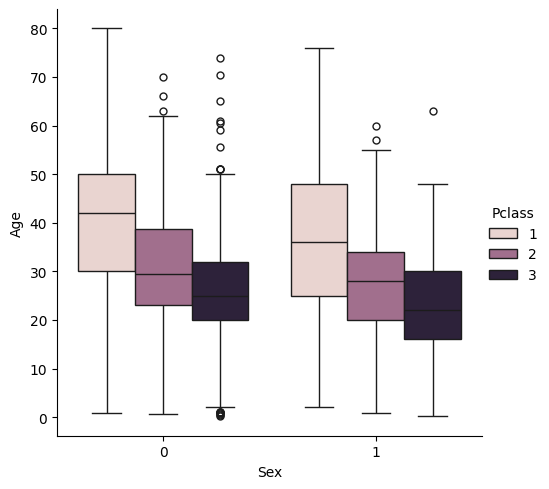

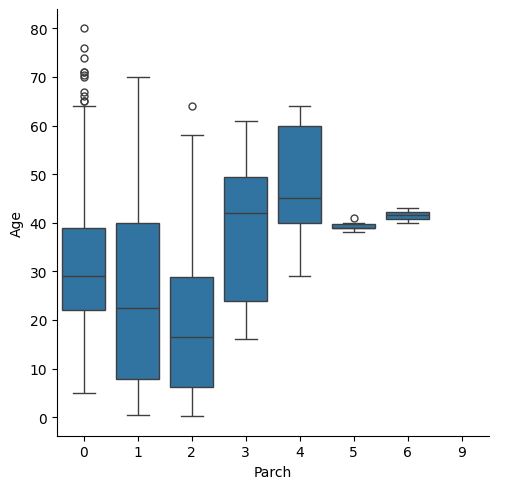

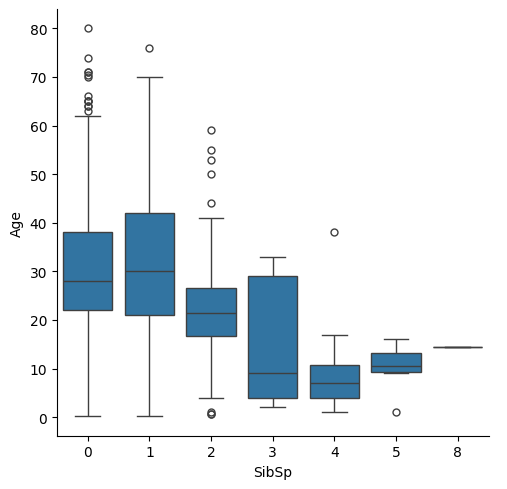

In [63]:
sns.catplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine)

<Axes: >

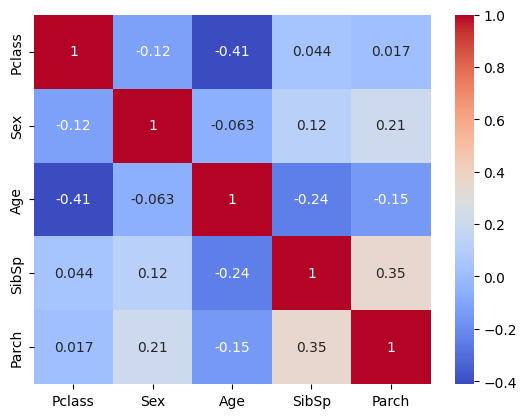

In [65]:
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare', 'Embarked'], axis = 1).corr(), annot = True, cmap = 'coolwarm')
# Dropping 'Embarked' column in addition to the existing columns since Embarked has string values and corr() works on numeric values.

Age is not correlated with Sex but is negatively correlated with SibSp, Parch and Pclass.

In [66]:
# Check number of missing ages

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

Loop through each missing age in the list to locate the rows that have the same SibSp, Parch and PClass values and fill the missing age with the median of those rows. If rows are not found, simply fill the missing age with the median of the entire Age column.

In [67]:
# Loop through list and impute missing ages

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp'])
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [68]:
# Make sure there is no more missing ages

combine['Age'].isnull().sum()

0

## 5.2 Data transformation

Recall that our passenger fare column has a very high positive skewness. Therefore, we will apply a log transformation to address this issue.

Text(0.5, 1.0, 'Passenger Fare Distribution')

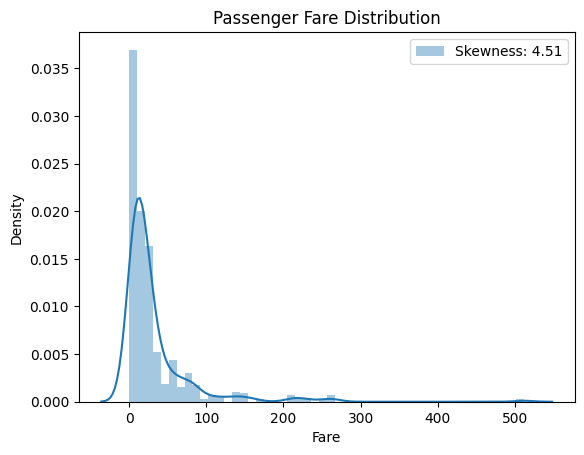

In [69]:
# Passenger fare distribution

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [70]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

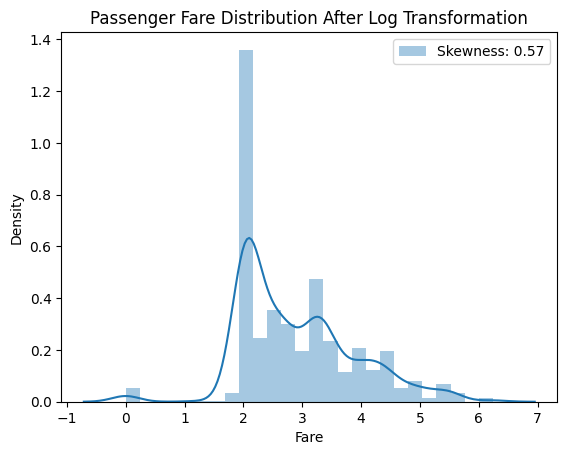

In [71]:
# Passenger fare distribution after log transformation

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

## 5.3 Feature engineering

Feature engineering is arguably the most important art in machine learning. It is the process of creating new features from existing features to better represent the underlying problem to the predictive models resulting in improved model accuracy on unseen data.

In this section, I will construct 3 new features:
- Title
- IsAlone
- Age*Class

## 5.3.1 Title

In [72]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,S


In [73]:
# Get title from name

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [74]:
# Value counts of Title

combine['Title'].value_counts()

,count
Title,
Mr,753
Miss,255
Mrs,197
Master,60
Rev,8
Dr,8
Col,4
Mlle,2
Major,2


In [75]:
# Number of unique Title

combine['Title'].nunique()

18

In [76]:
# Simplify title

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

<Axes: xlabel='count', ylabel='Title'>

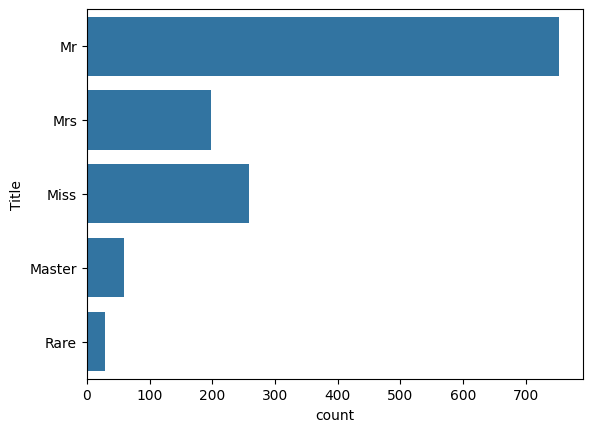

In [77]:
sns.countplot(combine['Title'])

In [78]:
# Mean of survival by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


Text(0.5, 1.0, 'Mean of survival by Title')

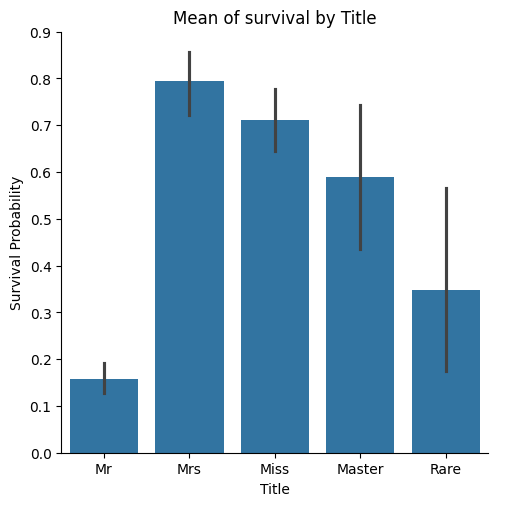

In [80]:
sns.catplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [81]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,S,Mr


## 5.3.2 IsAlone

In [82]:
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [83]:
# Mean of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [84]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [85]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [86]:
# Drop SibSp, Parch and FamilySize features from combine dataframe

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,Mrs,0
2,3,1.0,3,1,26.0,2.070022,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,Mrs,0
4,5,0.0,3,0,35.0,2.085672,S,Mr,1


## 5.3.3 Age*Class

To create our new Age*Class feature, we need to first transform Age into an ordinal variable. Ordinal variable is much like a categorical variable but with intrisinc ordering in their values.

We will group Ages into 5 separate age bands and assign a number to each age band.

In [87]:
# Create age bands and compute mean of survival by age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [88]:
# Assign ordinals to each age band

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [89]:
# Drop age band feature

combine = combine.drop('AgeBand', axis = 1)

In [90]:
# Age and Pclass data types

combine[['Age', 'Pclass']].dtypes

,0
Age,float64
Pclass,int64


In [91]:
# Convert ordinal Age into integer

combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype

dtype('int64')

In [92]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


## 5.4 Feature encoding

Machine learning models require all input and output variables to be numeric. Therefore, we need to encode all of our categorical data before we can fit the models to our data.

Previously, we have encoded the sex column such that 0 = male and 1 = female. We need to repeat this process for Title and Embarked. In addition, similar to the age column, I will also transform Fare into an ordinal variable rather than a continuous variable.

In [93]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,1,0.0,3,0,1,1.981001,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,C,Mrs,0,2
2,3,1.0,3,1,1,2.070022,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,S,Mrs,0,2
4,5,0.0,3,0,2,2.085672,S,Mr,1,6


In [94]:
# Encode Title and Embarked feature

combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,4.266662,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,2.070022,1,3,False,True,False,False,False,False,False,True
3,4,1.0,1,1,2,3.972177,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,2,2.085672,1,6,False,False,True,False,False,False,False,True


In [95]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [96]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [97]:
# Convert Fare into integer

combine['Fare'] = combine['Fare'].astype('int')

In [98]:
# Drop FareBand feature

combine = combine.drop('FareBand', axis = 1)

In [99]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,2,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,True
3,4,1.0,1,1,2,2,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,True


In [100]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [101]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,2,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,True
3,4,1.0,1,1,2,2,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,True


In [102]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,True
1,1.0,1,1,2,2,0,2,False,False,False,True,False,True,False,False
2,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,True
3,1.0,1,1,2,2,0,2,False,False,False,True,False,False,False,True
4,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,True


In [103]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,False,False,True,False,False,False,False,True
1,1,1,1,2,2,0,2,False,False,False,True,False,True,False,False
2,1,3,1,1,1,1,3,False,True,False,False,False,False,False,True
3,1,1,1,2,2,0,2,False,False,False,True,False,False,False,True
4,0,3,0,2,1,1,6,False,False,True,False,False,False,False,True


In [104]:
test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,NaN,3,0,2,1,1,6,False,False,True,False,False,False,True,False
882,893,NaN,3,1,2,1,0,6,False,False,False,True,False,False,False,True
883,894,NaN,2,0,3,1,1,6,False,False,True,False,False,False,True,False
884,895,NaN,3,0,1,1,1,3,False,False,True,False,False,False,False,True
885,896,NaN,3,1,1,1,0,3,False,False,False,True,False,False,False,True


In [105]:
# Drop passenger survived column from test set

test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,3,0,2,1,1,6,False,False,True,False,False,False,True,False
882,893,3,1,2,1,0,6,False,False,False,True,False,False,False,True
883,894,2,0,3,1,1,6,False,False,True,False,False,False,True,False
884,895,3,0,1,1,1,3,False,False,True,False,False,False,False,True
885,896,3,1,1,1,0,3,False,False,False,True,False,False,False,True


Our dataframes are ready for modelling!

# 6. Modelling

Scikit-learn is one of the most popular libraries for machine learning in Python and that is what we will use in the modelling part of this project.

Since Titanic is a classfication problem, we will need to use classfication models, also known as classifiers, to train on our model to make predictions. I highly recommend checking out this scikit-learn [documentation](https://scikit-learn.org/stable/index.html) for more information on the different machine learning models available in their library. I have chosen the following classifiers for the job:

- Logistic regression
- Support vector machines
- K-nearest neighbours
- Gaussian naive bayes
- Perceptron
- Linear SVC
- Stochastic gradient descent
- Decision tree
- Random forest
- CatBoost

In this section of the notebook, I will fit the models to the training set as outlined above and evaluate their accuracy at making predictions. Once the best model is determined, I will also do hyperparameter tuning to further boost the performance of the best model.

## 6.1 Split training data

We need to first split our training data into independent variables or predictor variables, represented by X as well as  dependent variable or response variable, represented by Y.

Y_train is the survived column in our training set and X_train is the other columns in the training set excluding the Survived column. Our models will learn to classify survival, Y_train based on all X_train and make predictions on X_test.

In [106]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 14)
Y_train shape:  (881,)
X_test shape:  (418, 14)


## 6.2 Fit model to data and make predictions

This requires 3 simple steps: instantiate the model, fit the model to the training set and predict the data in test set.

## 6.2.1 Logistic regression

In [107]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.93

## 6.2.2 Support vector machines

In [108]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.09

## 6.2.3 K-nearest neighbours (KNN)

In [109]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.56

## 6.2.4 Gaussian naive bayes

In [110]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.11

## 6.2.5 Perceptron

In [111]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.57

## 6.2.6 Linear SVC

In [112]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.25

## 6.2.7 Stochastic gradient descent

In [113]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.82

## 6.2.8 Decision tree

In [114]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.7

## 6.2.9 Random forest

In [115]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.7

## 6.2.10 CatBoost

In [116]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6868136	total: 46.9ms	remaining: 46.9s
1:	learn: 0.6798485	total: 48ms	remaining: 24s
2:	learn: 0.6729520	total: 49ms	remaining: 16.3s
3:	learn: 0.6669729	total: 50ms	remaining: 12.5s
4:	learn: 0.6607853	total: 51ms	remaining: 10.1s
5:	learn: 0.6554568	total: 51.9ms	remaining: 8.6s
6:	learn: 0.6500727	total: 52.9ms	remaining: 7.5s
7:	learn: 0.6437982	total: 54.1ms	remaining: 6.71s
8:	learn: 0.6398272	total: 55ms	remaining: 6.05s
9:	learn: 0.6351628	total: 56.1ms	remaining: 5.55s
10:	learn: 0.6305969	total: 56.6ms	remaining: 5.09s
11:	learn: 0.6252274	total: 57.6ms	remaining: 4.74s
12:	learn: 0.6203165	total: 58.5ms	remaining: 4.44s
13:	learn: 0.6163249	total: 59.3ms	remaining: 4.18s
14:	learn: 0.6126752	total: 60.3ms	remaining: 3.96s
15:	learn: 0.6078515	total: 61.2ms	remaining: 3.77s
16:	learn: 0.6033553	total: 62.2ms	remaining: 3.6s
17:	learn: 0.5984437	total: 63.3ms	remaining: 3.45s
18:	learn: 0.5935188	total: 64.4ms	remaining: 3.32s
19:	lear

In [117]:
acc_catboost

85.7

## 6.3 Model evaluation and hyperparameter tuning

Once all our models have been trained, the next step is to assess the performance of these models and select the one which has the highest prediction accuracy.

## 6.3.1 Training accuracy

Training accuracy shows how well our model has learned from the training set.

In [118]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent',
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,85.70
1,Decision Tree,85.70
2,CatBoost,85.70
3,KNN,84.56
4,Support Vector Machines,83.09
5,Logistic Regression,80.93
6,Stochastic Gradient Decent,80.82
7,Linear SVC,80.25
8,Perceptron,79.57
9,Naive Bayes,79.11


## 6.3.2 K-fold cross validation

It is important to not get too carried away with models with impressive training accuracy as what we should focus on instead is the model's ability to predict out-of-samples data, in other words, data our model has not seen before.

This is where k-fold cross validation comes in. K-fold cross validation is a technique whereby a subset of our training set is kept aside and will act as holdout set for testing purposes. Here is a great [video](https://www.youtube.com/watch?v=fSytzGwwBVw) explaining the concept in more detail.

In [119]:
# Create a list which contains classifiers

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [120]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6671644	total: 6.12ms	remaining: 1.22s
5:	learn: 0.6624480	total: 6.95ms	remaining: 1.15s
6:	learn: 0.6564807	total: 7.93ms	remaining: 1.13s
7:	learn: 0.6508291	total: 8.91ms	remaining: 1.1s
8:	learn: 0.6458787	total: 9.88ms	remaining: 1.09s
9:	learn: 0.6404126	total: 10.9ms	remaining: 1.07s
10:	learn: 0.6355068	total: 11.8ms	remaining: 1.06s
11:	learn: 0.6301715	total: 12.8ms	remaining: 1.05s
12:	learn: 0.6268281	total: 13.6ms	remaining: 1.03s
13:	learn: 0.6224645	total: 14.5ms	remaining: 1.02s
14:	learn: 0.6181694	total: 15.5ms	remaining: 1.02s
15:	learn: 0.6130410	total: 16.3ms	remaining: 1s
16:	learn: 0.6077487	total: 17ms	remaining: 983ms
17:	learn: 0.6028485	total: 18.5ms	remaining: 1.01s
18:	learn: 0.5982086	total: 20.9ms	remaining: 1.08s
19:	learn: 0.5934682	total: 22ms	remaining: 1.08s
20:	learn: 0.5894552	total: 22.8ms	remaining: 1.06s
21:	learn: 0.5852499	total: 23.5ms	remaining: 1.05s
22:	learn: 0.5809276	total:

In [121]:
# Mean and standard deviation of cross validation results for each classifier

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [122]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.821782,0.042574,Support Vector Machines
1,0.817275,0.035240,KNN
2,0.815028,0.036378,CatBoost
3,0.804801,0.029279,Logistic Regression
4,0.801404,0.027106,Random Forest
5,0.800243,0.033294,Linear SVC
6,0.790041,0.024733,Decision Tree
7,0.783223,0.041915,Gausian Naive Bayes
8,0.767339,0.042102,Stochastic Gradient Descent
9,0.733287,0.043881,Perceptron


ValueError: 'xerr' (shape: (10,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

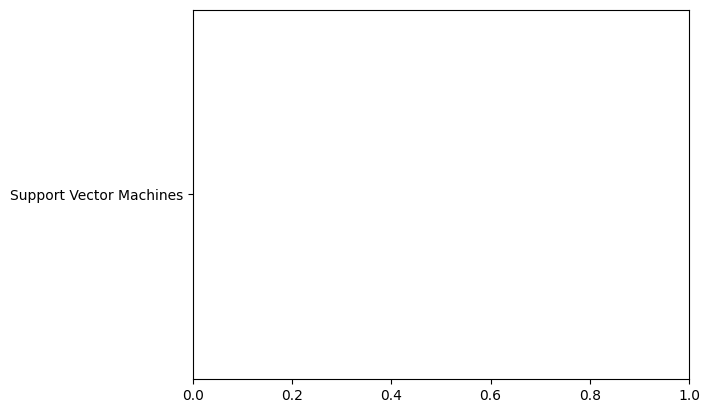

In [126]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

As we can see, support vector machines has the highest cross validation mean and thus we will proceed with this model.

## 6.3.3 Hyperparameter tuning for SVM

Hyperparameter tuning is the process of tuning the parameters of a model. Here I will tune the parameters of support vector classifier using GridSearchCV.

In [127]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.716 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.814 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.718 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [128]:
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.01)


In [129]:
# Training accuracy

svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.54

In [130]:
# Mean cross validation score

cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8297242083758938

Our mean cross validation score improved slightly.

In [131]:
# Survival predictions by support vector classifier

Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [132]:
len(Y_pred)

418

# 7. Preparing data for submission

In [133]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [134]:
ss.shape

(418, 2)

We want our submission dataframe to have 418 rows and 2 columns, PassengerId and Survived.

In [135]:
# Create submission dataframe

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1


In [136]:
submit.shape

(418, 2)

Our dataframe is ready for submission!

In [138]:
# Create and save csv file

submit.to_csv("/content/svm_titanic.csv", index = False)

# 8. Possible extensions to improve model accuracy

1. Analyse ticket and cabin features
    - Do these features help predict passenger survival?
    - If yes, consider including them in the training set instead of dropping
2. Come up with alternative features in feature engineering
    - Is there any other features you can potentially create from existing features in the dataset
3. Remove features that are less important
    - Does removing features help reduce overfitting in the model?
4. Ensemble modelling
    - This is a more advanced technique whereby you combine prediction results from multiple machine learning models

# 9. Conclusion

You should achieve a submission score of 0.77511 if you follow exactly what I have done in this notebook. In other words, I have correctly predicted 77.5% of the test set. I highly encourage you to work through this project again and see if you can improve on this result.

If you found any mistakes in the notebook or places where I can potentially improve on, feel free to reach out to me. Let's help each other get better - happy learning!

My platforms:
- [Facebook](https://www.facebook.com/chongjason914)
- [Instagram](https://www.instagram.com/chongjason914)
- [Twitter](https://www.twitter.com/chongjason914)
- [LinkedIn](https://www.linkedin.com/in/chongjason914)
- [YouTube](https://www.youtube.com/channel/UCQXiCnjatxiAKgWjoUlM-Xg?view_as=subscriber)
- [Medium](https://www.medium.com/@chongjason)